In [3]:
#importing the necessary modules 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
#function to plot the points for displacment, velocity and acceleration
def BetaNewmark(M,K,C,F,time,x0,v0,dt):
    time_step =np.arange(0,time,dt)
    u = np.zeros(len(time_step))
    v = np.zeros(len(time_step))
    a = np.zeros(len(time_step))

    alpha =1/4 # Newmark parameter
    beta = 1/2 # Damping parameter
    u[0] = x0
    v[0] = v0
    a[0] = (F[0] - C*v0 -K*x0)/M

    # coefficients 
    c1 = 1/(alpha * (dt**2))
    c2 = 1/(alpha*dt)
    c3 = (1/(2*alpha)) -1
    c4 = beta *c2
    c5 = (beta/alpha)-1
    c6 = (beta/alpha)-2
    c7 = (1-beta)*dt
    c8 = (beta*dt)


    for i in range(0,len(time_step)-1):
        u[i+1] = (M*(c1*u[i] + c2*v[i] + c3*a[i]) + C*(c4*u[i] + c5*v[i] + c6 *a[i]*(dt/2)) + F[i+1])/(c1*M + c4*C + K)
        a[i+1] = c1*(u[i+1] - u[i]) - c2*v[i] - c3*a[i]
        v[i+1] =  v[i] + c7*a[i] + c8*a[i+1]
        
    return u,v,a

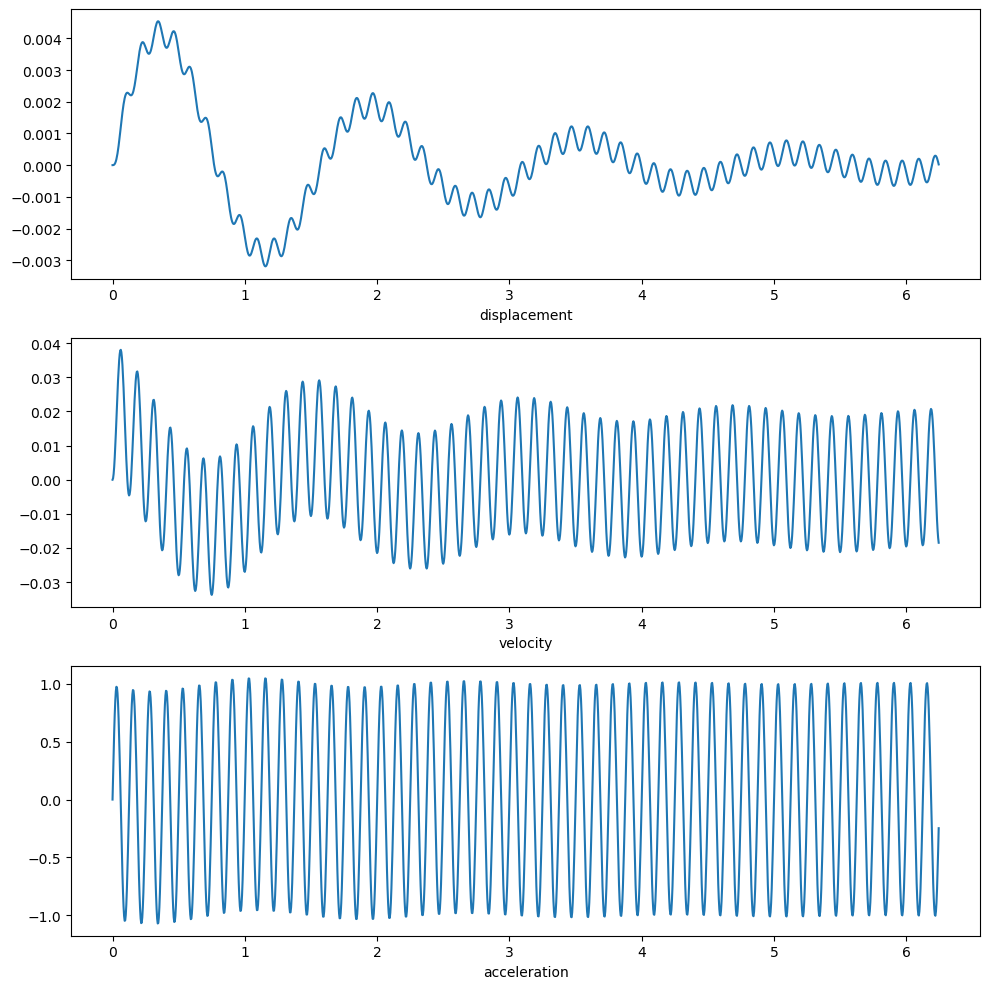

In [5]:
K = 16                 # stiffness N/m
M = 1                  # mass kg
C = 1                  # damping N-s/m
F0 = 1                 # Force amplitude N
x0 =0                  # Initial displacement
v0 =0                  # Intial velocity
dt = 0.125/30          # del t - time step size (0.125 is time period of applied force divided by no of iterations)
time = 50              # Total time to solve
pi=3.141
stime=1500

# Force vector calculation
time_step = np.arange(0,time,dt)
F_freq = 8                     # Force frequency Hz
omega = F_freq * 2*pi
F = F0*np.sin(omega*time_step)

# Displacement calculation
u,v,a = BetaNewmark(M,K,C,F,time,x0,v0,dt)

plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(time_step[:stime],u[:stime])
plt.xlabel('displacement')

plt.subplot(3,1,2)
plt.plot(time_step[:stime],v[:stime])
plt.xlabel('velocity')

plt.subplot(3,1,3)
plt.plot(time_step[:stime],a[:stime])
plt.xlabel('acceleration')

plt.tight_layout()


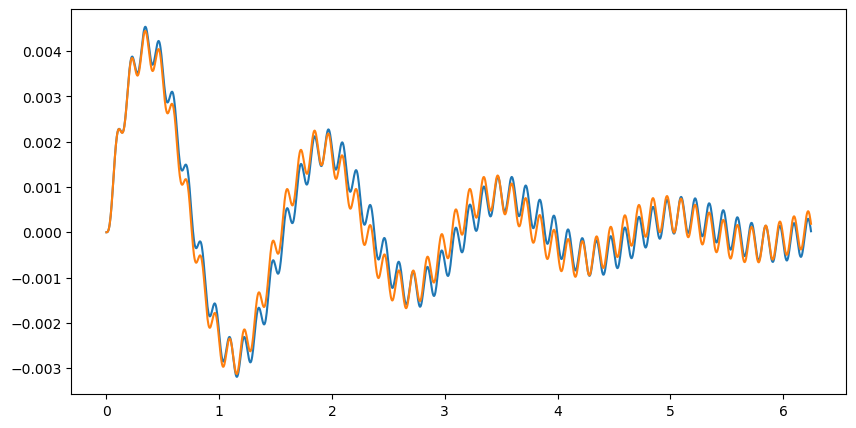

In [6]:
#comparing curves with two different values of K
u1,v1,a1 = BetaNewmark(M,K,C,F,time,x0,v0,dt)
u2,v2,a2 = BetaNewmark(M,K+1,C,F,time,x0,v0,dt)

plt.figure(figsize=(10,5))
plt.plot(time_step[:stime],u[:stime])
plt.plot(time_step[:stime],u2[:stime])

In [7]:
#getting curves for different values of K
curves=[]
Kvalue=[]
for i in range(10):
    u,v,a = BetaNewmark(M,K+i,C,F,time,x0,v0,dt)
    curves.append(u)
    Kvalue.append(K+i)

In [8]:
#scaling the data
# from sklearn.preprocessing import StandardScaler
# scaler=StandardScaler()
# scaler.fit(x)
# x=scaler.transform(x)
for index,curve in enumerate(curves):
    curves[index]=curves[index]*1000

In [192]:
#making the iput data for the lstm model 
x=[]
y=[]
sequence_length=100
for i in range(len(curves[0])-sequence_length):
    x.append(curves[0][i:i+sequence_length])
    y.append(curves[0][i+sequence_length])

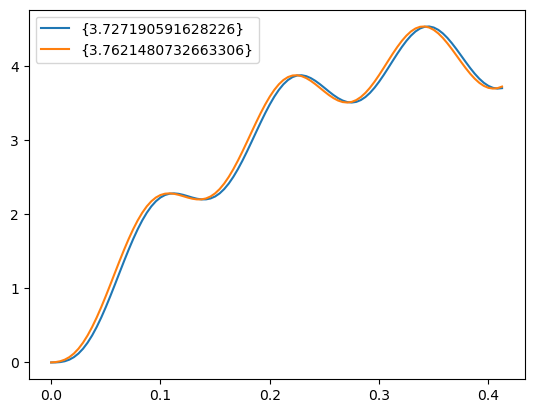

In [193]:
#comparing the adjacent data
plt.plot(time_step[:sequence_length],x[0],label={y[0]})
plt.plot(time_step[:sequence_length],x[1],label={y[1]})
plt.legend()

In [194]:
#splitting the data for testing and training
x=np.array(x)
y=np.array(y)
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y)

In [195]:
#importing modules for building the model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM,Dense

In [196]:
#adding layers to the model
model = Sequential()
model.add(LSTM(units=16, input_shape=(sequence_length, 1), return_sequences=True))
model.add(LSTM(units=8, return_sequences=False))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [197]:
#fitting the dataset to the model
model.fit(x_train,y_train,batch_size=10,epochs=5)

Epoch 1/5
893/893 [==============================] - 28s 29ms/step - loss: 0.0283
Epoch 2/5
893/893 [==============================] - 26s 29ms/step - loss: 0.0020
Epoch 3/5
893/893 [==============================] - 26s 30ms/step - loss: 9.8247e-04
Epoch 4/5
893/893 [==============================] - 26s 29ms/step - loss: 6.2186e-04
Epoch 5/5
893/893 [==============================] - 27s 30ms/step - loss: 5.1018e-04


In [198]:
#predicting the label
predictions=model.predict(x_test)

93/93 [==============================] - 1s 6ms/step


In [199]:
def arrtonum(arr):
    return arr[0]
predictions=np.array(list(map(arrtonum,predictions)))

/Users/nitinrohit/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

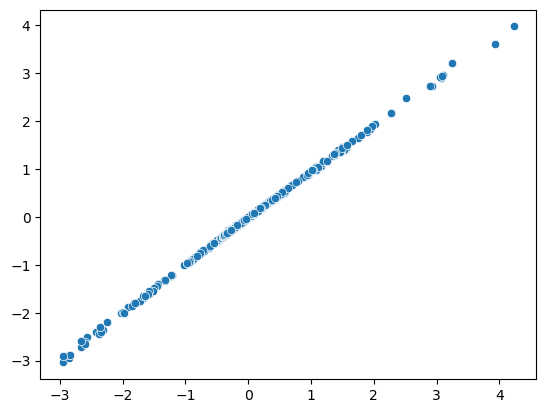

In [200]:
#checking the accuarcy using scatter plot
sns.scatterplot(y_test,predictions)

<AxesSubplot:ylabel='Count'>

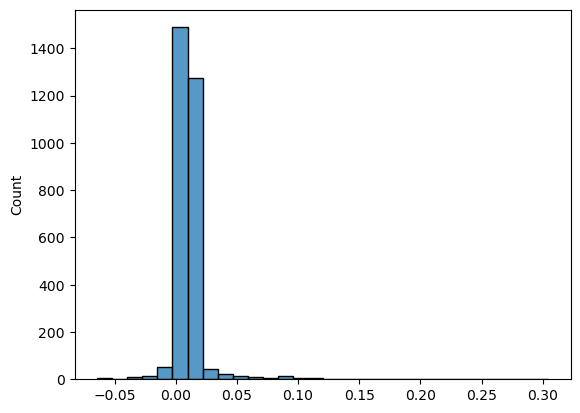

In [241]:
#checking the error distribution using histogram
sns.histplot(y_test-predictions,bins=30)

372/372 [==============================] - 2s 6ms/step


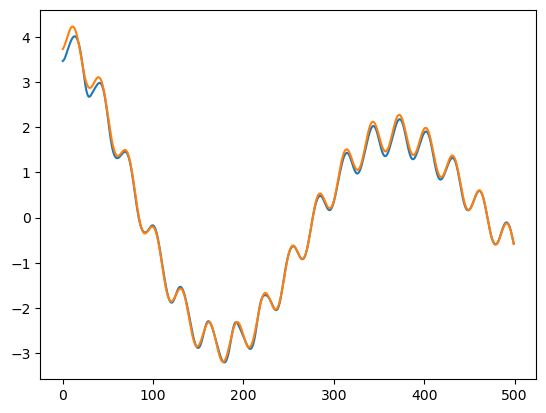

In [260]:
#seeing how the predicted and actual plot look like
temp=model.predict(x)

length=500
plt.plot(range(length),temp[:length])
plt.plot(range(length),curves[0][sequence_length:sequence_length+length])

In [233]:
#checking how the model is preforming for other values of K
num=8

kemp=[]
for i in range(len(curves[num])-sequence_length):
    kemp.append(curves[num][i:i+sequence_length])
kemp=np.array(kemp)

In [234]:
lemp=model.predict(kemp)

372/372 [==============================] - 2s 6ms/step


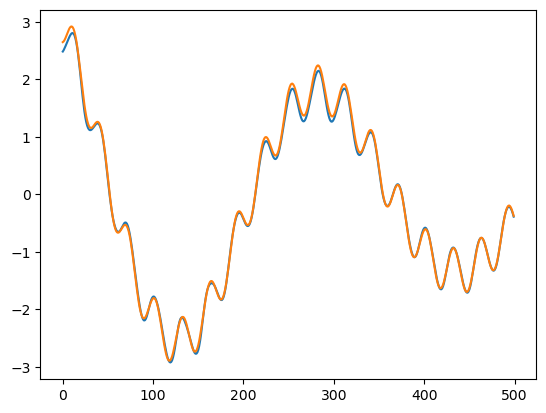

In [239]:
plt.plot(range(length),lemp[:length])
plt.plot(range(length),curves[num][sequence_length:sequence_length+length])

In [257]:
#checking how the model is working on different value of M and K
u,v,a = BetaNewmark(M+4,K+4,C,F,time,x0,v0,dt)
u=u*1000
hemp=[]
for i in range(len(u)-sequence_length):
    hemp.append(u[i:i+sequence_length])
hemp=np.array(hemp)

pemp=model.predict(hemp)

372/372 [==============================] - 2s 6ms/step


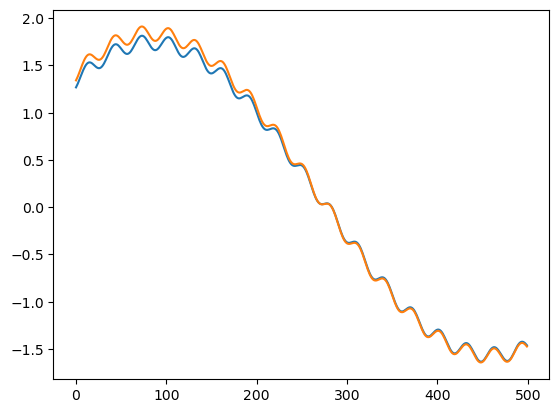

In [258]:
plt.plot(range(length),pemp[:length])
plt.plot(range(length),u[sequence_length:sequence_length+length])

In [384]:
#making dataset to predict the k value using lstm 
xdata=[]
ydata=[]
for index,curve in enumerate(curves):
    xdata.append(curve[:sequence_length])
    ydata.append(Kvalue[index])
xdata=np.array(xdata)
ydata=np.array(ydata)

In [385]:
#making a linear regression model to add at the end of lstm model
from sklearn.linear_model import LinearRegression
model3=LinearRegression()

In [392]:
#adding layers to the model
model2 = Sequential()
model2.add(LSTM(units=16, input_shape=(sequence_length, 1), return_sequences=True))
model2.add(LSTM(units=8, return_sequences=False))
model2.add(Dense(10))
model2.add(Dense(1))

model2.compile(loss='mean_squared_error', optimizer='adam')

In [393]:
#making functions to connect the lstm and linear Regression model
def modelFit(x,y):
    model2.fit(x,y,epochs=500)
    p=model2.predict(x)
    model3.fit(p,y)
    
def modelPredict(x):
    return model3.predict(model2.predict(x))

In [394]:
#fitting the data
modelFit(xdata,ydata)

Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 426.2585
Epoch 2/500
1/1 [==============================] - 0s 39ms/step - loss: 420.8430
Epoch 3/500
1/1 [==============================] - 0s 37ms/step - loss: 415.1512
Epoch 4/500
1/1 [==============================] - 0s 38ms/step - loss: 409.0690
Epoch 5/500
1/1 [==============================] - 0s 29ms/step - loss: 402.8514
Epoch 6/500
1/1 [==============================] - 0s 35ms/step - loss: 397.0247
Epoch 7/500
1/1 [==============================] - 0s 34ms/step - loss: 391.9926
Epoch 8/500
1/1 [==============================] - 0s 34ms/step - loss: 387.7628
Epoch 9/500
1/1 [==============================] - 0s 33ms/step - loss: 384.0738
Epoch 10/500
1/1 [==============================] - 0s 32ms/step - loss: 380.6740
Epoch 11/500
1/1 [==============================] - 0s 29ms/step - loss: 377.4203
Epoch 12/500
1/1 [==============================] - 0s 33ms/step - loss: 374.2444
Epoch 13/500
1/1 [=========

1/1 [==============================] - 0s 33ms/step - loss: 126.4211
Epoch 102/500
1/1 [==============================] - 0s 33ms/step - loss: 124.2321
Epoch 103/500
1/1 [==============================] - 0s 33ms/step - loss: 122.0708
Epoch 104/500
1/1 [==============================] - 0s 32ms/step - loss: 119.9375
Epoch 105/500
1/1 [==============================] - 0s 33ms/step - loss: 117.8321
Epoch 106/500
1/1 [==============================] - 0s 33ms/step - loss: 115.7547
Epoch 107/500
1/1 [==============================] - 0s 33ms/step - loss: 113.7053
Epoch 108/500
1/1 [==============================] - 0s 32ms/step - loss: 111.6839
Epoch 109/500
1/1 [==============================] - 0s 33ms/step - loss: 109.6904
Epoch 110/500
1/1 [==============================] - 0s 33ms/step - loss: 107.7248
Epoch 111/500
1/1 [==============================] - 0s 32ms/step - loss: 105.7870
Epoch 112/500
1/1 [==============================] - 0s 33ms/step - loss: 103.8769
Epoch 113/500
1/1 

1/1 [==============================] - 0s 34ms/step - loss: 8.3951
Epoch 301/500
1/1 [==============================] - 0s 33ms/step - loss: 8.3884
Epoch 302/500
1/1 [==============================] - 0s 33ms/step - loss: 8.3820
Epoch 303/500
1/1 [==============================] - 0s 33ms/step - loss: 8.3759
Epoch 304/500
1/1 [==============================] - 0s 33ms/step - loss: 8.3701
Epoch 305/500
1/1 [==============================] - 0s 32ms/step - loss: 8.3646
Epoch 306/500
1/1 [==============================] - 0s 32ms/step - loss: 8.3594
Epoch 307/500
1/1 [==============================] - 0s 33ms/step - loss: 8.3544
Epoch 308/500
1/1 [==============================] - 0s 32ms/step - loss: 8.3497
Epoch 309/500
1/1 [==============================] - 0s 32ms/step - loss: 8.3452
Epoch 310/500
1/1 [==============================] - 0s 34ms/step - loss: 8.3410
Epoch 311/500
1/1 [==============================] - 0s 33ms/step - loss: 8.3369
Epoch 312/500
1/1 [=======================

In [395]:
#predictin the k value
pp=modelPredict(xdata)

1/1 [==============================] - 0s 28ms/step


/Users/nitinrohit/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

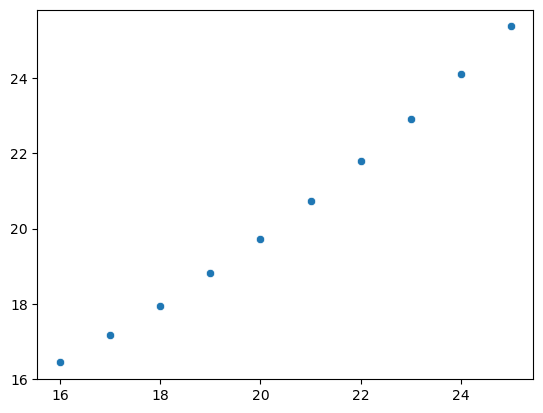

In [396]:
sns.scatterplot(ydata,pp)

<AxesSubplot:ylabel='Count'>

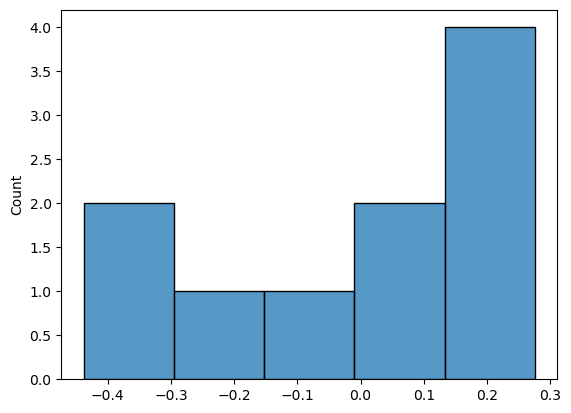

In [400]:
sns.histplot(ydata-pp)

In [461]:
new=[]
Knew=[]
for i in range(20):
    u,v,a = BetaNewmark(M,K+i*0.5,C,F,time,x0,v0,dt)
    new.append(u[:sequence_length]*1000)
    Knew.append(K+i*0.5)
new=np.array(new)

In [462]:
temp=modelPredict(new)

1/1 [==============================] - 0s 28ms/step


/Users/nitinrohit/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

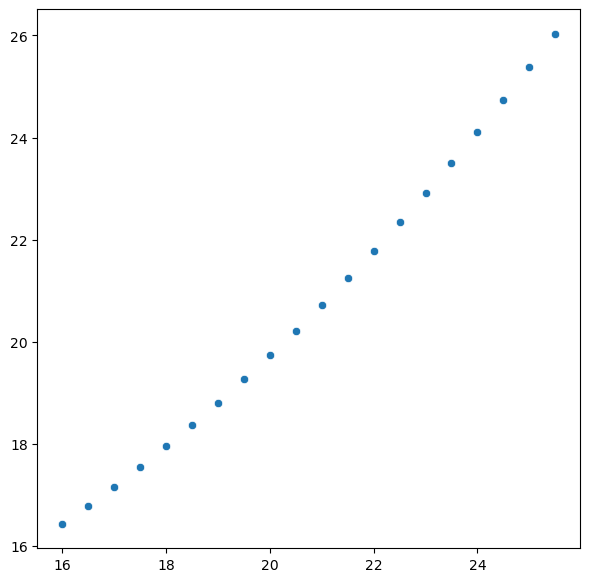

In [463]:
plt.figure(figsize=(7,7))
sns.scatterplot(Knew,temp)

In [9]:
curves

[array([0.        , 0.00090029, 0.00535841, ..., 0.34921502, 0.30301383,
        0.24357447]),
 array([0.        , 0.00090028, 0.00535837, ..., 0.34935168, 0.30313168,
        0.24366835]),
 array([0.        , 0.00090028, 0.00535833, ..., 0.34948845, 0.30324962,
        0.2437623 ]),
 array([0.        , 0.00090028, 0.00535829, ..., 0.34962532, 0.30336765,
        0.24385633]),
 array([0.        , 0.00090027, 0.00535825, ..., 0.34976231, 0.30348577,
        0.24395043]),
 array([0.        , 0.00090027, 0.00535821, ..., 0.34989939, 0.30360398,
        0.2440446 ]),
 array([0.        , 0.00090027, 0.00535817, ..., 0.35003659, 0.30372228,
        0.24413885]),
 array([0.        , 0.00090026, 0.00535814, ..., 0.3501739 , 0.30384068,
        0.24423316]),
 array([0.        , 0.00090026, 0.0053581 , ..., 0.35031131, 0.30395917,
        0.24432755]),
 array([0.        , 0.00090025, 0.00535806, ..., 0.35044883, 0.30407775,
        0.24442202])]

In [ ]:
curves.to_csv('temp.csv')